# 自動作曲AI 多層LSTM+4出力 ver221002最終

### ●制作 ： K.U  /  制作期間 ： 220625～221002 /  AI長期2022/3月期 自走課題

参考文献と本program概要

In [1]:
#------------------------------------------------------------------------
# 参考文献
#------------------------------------------------------------------------
# (1) LSTM基本 ＠music21
#     https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5
#     https://github.com/jordan-bird/Keras-LSTM-Music-Generator
# (2) RNN基本 ＠Pretty_midi (tensorflowチュートリアル)
#     https://www.tensorflow.org/tutorials/audio/music_generation
# (3) key変換方法 ＠music21
#     http://nickkellyresearch.com/python-script-transpose-midi-files-c-minor/
# (4) 自動作曲AI最新状況
#     https://speakerdeck.com/suzuqn/muana-20220629?slide=10
# (5) tensorflow/kerasの使い方（初心者用）
#     https://note.nkmk.me/python-tensorflow-keras-basics/
# (6) tensorflow datasetの作り方
#     https://qiita.com/norifumi92/items/1033c52f5c9e10efe6bf
#     https://blog.amedama.jp/entry/tf-dataset-api
#     https://www.tensorflow.org/api_docs/python/tf/data/Dataset
#     https://keras.io/ja/getting-started/faq/#_9
# (7) 評価指標
#     https://notebooks.githubusercontent.com/view/ipynb?browser=chrome&color_mode=auto&commit=6ef3e1ca6c461559ee08ce868d38a6ef99e1ee00&device=unknown&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f74656e736f72666c6f772f646f63732d6c31306e2f366566336531636136633436313535396565303863653836386433386136656639396531656530302f736974652f6a612f7475746f7269616c732f717569636b73746172742f626567696e6e65722e6970796e62&logged_in=false&nwo=tensorflow%2Fdocs-l10n&path=site%2Fja%2Ftutorials%2Fquickstart%2Fbeginner.ipynb&platform=android&repository_id=235856774&repository_type=Repository&version=98
#     https://qiita.com/FukuharaYohei/items/fe73cdb63ee82a7ea318# 
# (8) optuna for keras
#     https://www.salesanalytics.co.jp/datascience/datascience073/
# (9) 正規化
#     https://note-tech.com/python_scaling_standardize/
# (10) keras LSTM
#     https://qiita.com/pocokhc/items/c94512e5536ddd5b1bba
#     https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
# (11) midi楽器一覧
#     http://ganesha.phys.h.kyoto-u.ac.jp/~sakagami/dir/ChaosEmotion1.2/MIDI%E6%A5%BD%E5%99%A8%E5%90%8D%E4%B8%80%E8%A6%A7%E8%A1%A8.pdf
# (12) midiデータ
#     https://freemidi.org/
#     http://www.piano-midi.de/debuss.htm
#     https://www.piano-e-competition.com/midi_2018.asp
#     http://purepurepiano.main.jp/midi-yougaku.htm
# (13) tensorflow model保存再利用
#     https://note.com/mlai/n/n68fb660b506d
# (14) tensorboard
#     https://lsifrontend.hatenablog.com/entry/2019/02/27/201856
#     https://www.tensorflow.org/tensorboard/get_started
#
#------------------------------------------------------------------------
# ★★★ 本自動作曲AIのprogam概要 ★★★
#------------------------------------------------------------------------
# ・基本的な考え方は、上記（1）(2)を超参考したが、下記独自の工夫を入れた
#
# ・楽器は、pianoのみに取得。L/R、複数pianoはmidi結合して取得可能化。
#
# ・少量データでも、学習できるように工夫
#   ① 楽曲をKey Cmajorへ統合し、特定keyの学習データ化（一旦中止中221001）
#   ② inputsデータの中で、曲初めと他曲の終わりの混在させない独自アルゴリズム
#   ③ Datasetは、オリジナルコードで作成
# ・velocity追加し、入力特徴量4つで学習。表現力アップ。
#
# ・4出力のloss収束性と、lossバランスを取る為、下記のように工夫
#   ① 全特徴量を0～1に正規化 ＠ vocab sizeなど
#   ② lossの重みを手動により調整＠少量データ実験実験により決定
#      ⇒ 最終的に、Tensorflowチュートリアルを参考に
#
# ・音生成は、下記2つのモードをselectorで選べる
#   ①自分のフレーズをもとに音生成、②学習済みデータを使用し音生成(試運転用)
#
# ・なお、select_load_mode = 1にして、
#   付属のdata_notesデータ(大量のmidiデータをdf化etcしたもの)を使用すれば、
#   学習から開始できる（モデル検討時などに有効）。
#   data_notesは上書きするので要注意。
#
#------------------------------------------------------------------------
# 残課題memo 221002
#------------------------------------------------------------------------
# ①同じ音の繰り返しが生成されやすい
#   ⇒ 要因分離から、少なくとも、前処理(minmax normしても変化なし)、
#      生成時の初期音の与え方（きちんとフレーズを与えても変化なし）ではなかった。
#   ⇒ 4出力モデル、もしくはそのモデル精度甘い点が原因、と推定中。
#   ⇒ 要仮説検証と要改善。
#
# ②エラー対応文は一部のみ。
#
# ③予測時、自分のフレーズにつなげて生成するモードの場合、
#   sequence長よりもフレーズが短い場合のゼロ埋め対応できてない
#
# ④モデルのsave/loadの組み込み未実施
#
# まずは、試運転はepoch=5、学習時はepoch=200くらい

colab用install

In [1]:
# MIDIファイルを作成および解析
!pip install pretty_midi | tail -n 1
# key分析のみ使用（Cmajorに統一し次元削減狙い）
!pip install music21 | tail -n 1
# pyfluidsynthを使用してpyfluidsynthでオーディオ再生を生成
!sudo apt install -y fluidsynth | tail -n 1
!pip install --upgrade pyfluidsynth | tail -n 1
# HDF5フォーマットでモデルを保存するために必要
!pip install -q pyyaml h5py

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive



debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 5.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Mounted at /content/drive
/content/drive/MyDrive


import

In [10]:
import os
import sys
import glob
import collections
import datetime
import pickle
import random
from natsort import natsorted

import numpy as np
import pandas as pd
import seaborn as sns  # pianoroll表示用
import matplotlib.pyplot as plt

import pretty_midi     # midi読み込み用
from music21 import *  # midi scoreのkey分析のみで使用
import fluidsynth      # midi音源確認用

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import tensorflow.keras.utils as np_utils

from IPython.display import display

In [4]:
print(tf.version.VERSION)

2.8.2


### 1. midi読込みと前処理

In [11]:
def get_notes(midifiles):
    """ midiからnote取得 """
    print('\n-----------------------------------------------------------')
    all_notes  = [] # midiから変換したnotes
    midifile_n = [] # 各midiファイルのnote数を保持
    for f in midifiles:
        print(f'Parsing {f}')
        correct_interval = transport_to_Cmajor_key(f) # C majorにkey統一
        correct_interval = 0 # Key統一化をOFFする場合はON
        
        notes = midi_to_notes(f, correct_interval)

        midifile_n.append(len(notes))
        all_notes.append(notes)

    all_notes = pd.concat(all_notes)
    
    # 各midifileのデータ数nを保持するmidifile_n_dict
    midifile_n_dict = dict((f_no, n) for f_no, n in enumerate(midifile_n))
    print('*** midifile_n_dict :', midifile_n_dict)

    return all_notes, midifile_n_dict


def midifile_train_val_test_split(midi_dir, select_load_mode):
    """ 全midiファイルをtrain/val/test分割 (∵trainのみ正規化し易くする為) """
    train_midifiles = []
    val_midifies = [] 
    test_midifiles = [] 

    midifile = natsorted(glob.glob(os.path.join(midi_dir, '*.mid*')))

    random.shuffle(midifile)

    n_train = int(len(midifile) * 0.7)
    n_val   = int(len(midifile) * 0.2)
    n_test  = len(midifile) - n_train -n_val

    train_midifiles = midifile[0:n_train]
    val_midifiles   = midifile[n_train:n_train+n_val]
    test_midifiles  = midifile[n_train+n_val:]

    if select_load_mode == 1:
        print('midifile path  :', midifile)
        print('total midifile :', len(midifile))
        print('train / val /test midifiles数 :', len(train_midifiles), 
              ' / ', len(val_midifiles), ' / ', len(test_midifiles))
    
    return train_midifiles, val_midifiles, test_midifiles


def midi_to_notes(midi_file, correct_interval):
    """ midiをDataFrame化 """
    pm = pretty_midi.PrettyMIDI(midi_file)
    # 楽器数を取得（開発時チェック用）
    # print('pm.instruments', len(pm.instruments), '\n', pm.instruments)
    
    notes_dict = collections.defaultdict(list)

    for idx, track in enumerate(pm.instruments):
        # track楽器を取得（開発時チェック用）
        # inst = pm.instruments[idx]
        # inst_name = pretty_midi.program_to_instrument_name(inst.program)
        
        # piano trackのみ抽出(複数pianoパートは結合)
        if not track.is_drum and track.program == 0:
            # print('\tidx :',idx, '---> Inst name :', inst_name)
            instrument = pm.instruments[idx]
            
            # スタート音を設定 (memo: sortedは非破壊的処理)
            sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
            prev_start = sorted_notes[0].start
            # print('\tsorted_notes ====>', len(sorted_notes))
            # notesを分解し、dictに格納後にDataFrame化
            for note in sorted_notes:
                start = note.start
                end = note.end
                notes_dict['pitch'].append(int(note.pitch + correct_interval))
                notes_dict['start'].append(start)
                notes_dict['end'].append(end)
                notes_dict['step'].append(start - prev_start)
                notes_dict['duration'].append(round((end - start), 2))
                notes_dict['velocity'].append(int(note.velocity))
                prev_start = start
            # print('\tlen(dict) ====>', len(notes_dict['pitch']))
        
    return pd.DataFrame({name: np.array(value) for name, value in notes_dict.items()})


def transport_to_Cmajor_key(midi_file):
    """ music21で曲のkey分析 => C majorに変換(次元削減) """
    sc = converter.parse(midi_file)
    key = sc.analyze('key')
    
    majors = dict([('A-',4),('G#',4),('A',3),('A#',2),('B-',2),('B',1),('C',0),
                   ('C#',-1),('D-',-1),('D',-2),('D#',-3),('E-',-3),('E',-4),
                   ('F',-5),('F#',6),('G-',6),('G',5)])
    minors = dict([('G#',1),('A-',1),('A',0),('A#',-1),('B-',-1),('B',-2),
                   ('C',-3),('C#',-4),('D-',-4),('D',-5),('D#',6),('E-',6),
                   ('E',5),('F',4),('F#',3),('G-',3),('G',2)])
    
    if key.mode == 'major':
        correct_interval = majors[key.tonic.name]
    elif key.mode == 'minor':
        correct_interval = minors[key.tonic.name]
    # print('--- convert key step :',correct_interval)
    
    return correct_interval

### 2. Dataset準備

各種の初期設定セット

In [12]:
#============================================================================

# midiデータ読み込みmode selector
# midiデータloadからし直す：0
# 過去load済みmidiデータを使用：1
select_load_mode = 1

# 学習するかしないか（0:学習から実施、1:ベストモデルで音生成のみ実施）
generate_only_flag = 0

# 学習用midiデータファイル
BASE_DIR = '/content/drive/MyDrive/LSTM_test220810'

midi_dir = os.path.join(BASE_DIR, 'data')
notes_save_dir = os.path.join(BASE_DIR, 'data_notes')

# 入力特徴量の設定
key_order = ['pitch', 'step', 'duration', 'velocity']

# 各設定値 (trainデータ表現数にする方法もあるが、今回は通常midi：0～127フル表現数に)
vocab_size, vel_size = 128, 128

# Must : batch_size < seq_length
seq_length = 20
batch_size = 60
epochs = 200

#============================================================================

Dataset作成

In [13]:
def mk_dataset(select_load_mode, filepath, notes_save_dir,
               seq_length, key_order, vocab_size, vel_size, batch_size, 
               dataname, 
               df_name, dict_name):
    if select_load_mode == 1:
        notes_df, n_dict = load_notes(notes_save_dir, df_name, dict_name)
    else:
        notes_df, n_dict = get_notes(filepath)
    
    df = select_key_order(notes_df, key_order)
    seq_ds_list = prepare_sequences(df, n_dict, seq_length, key_order)
    ds = prepare_dataset(seq_ds_list, vocab_size, vel_size, batch_size, dataname)
    
    if select_load_mode != 1:
        save_notes(notes_save_dir, df_name, dict_name, notes_df, n_dict)
    
    return ds


def select_key_order(notes_df, key_order):
    """ key_orderにより指定した入力特徴量のみを取得 """
    return notes_df[key_order]


def prepare_sequences(notes_df, n_dict, seq_length, key_order):
    """ notes_dfをseqence幅(inputs+labelのset)に分割 """
    n_notes = len(notes_df)
    
    # 例) n_dict[i]=1300、seq_length=25にlabel分+1=26、buffer_size=1274
    seq_ds_list = []
    seq_length = seq_length + 1
    
    for i in range(len(n_dict)):
        buffer_size = n_dict[i] - seq_length
        
        for i in range(buffer_size+1):
            seq_ds_series = notes_df[i:i+seq_length].values.astype('float32')
            seq_ds_list.append(seq_ds_series)
    
    return seq_ds_list


def prepare_dataset(seq_ds_list, vocab_size, vel_size, batch_size, data_name):
    """ sequence長から、inputs/labelsに分割されたdatase準備 """    
    def split_labels(ds):
        inputs = ds[:-1]
        inputs = inputs / [vocab_size, 1.0, 1.0, vel_size] # 正規化部分
        labels_dense = ds[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}
        
        return inputs, labels

    # tensorflowのdataset化 => ダメ押しfloat32化 => inputs/labels分割
    ds = tf.data.Dataset.from_tensor_slices(seq_ds_list)
    ds = ds.map(lambda x: (tf.cast(x, tf.float32)))
    ds = ds.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)
    # trainのみshuffle
    if data_name == 'train':
        buffer_size = len(ds)
        ds = ds.shuffle(buffer_size)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    print(f'Prepare_dataset of {data_name} :', len(ds))
    print(ds.element_spec)
    print('')

    return ds


def save_notes(notes_save_dir, df_filename, dict_name, df, ndict):
    """ 大量に読み込んだmidiデータ情報を保存 (再学習時の効率化) """
    with open(os.path.join(notes_save_dir, df_filename), 'wb') as f:
        pickle.dump(df, f)
    with open(os.path.join(notes_save_dir, dict_name), 'wb') as f:
        pickle.dump(ndict, f)


def load_notes(notes_save_dir,df_filename, dict_name):
    """ 読み込み済midiのdfから各Dataset化を作成 """
    with open(os.path.join(notes_save_dir, df_filename), 'rb') as f:
        df = pickle.load(f)
    print(f'loading...{df_filename}')
    with open(os.path.join(notes_save_dir, dict_name), 'rb') as f:
        n_dict = pickle.load(f)
    print(f'loading...{dict_name}')

    return df, n_dict


# 未使用だがテスト記録の為、コード保存(minmax)：Seriesならばnumpy同様に要素の演算可
# def minmax_norm(df, train_df):
#     return (df - train_df.min()) / (train_df.max() - train_df.min())
#
# def inverse_minmax_norm(df, train_df):
#     return (df *  (train_df.max() - train_df.min())) + train_df.min()

In [8]:
# 読み込んだtrain etcデータ保存フォルダ
if not os.path.exists(notes_save_dir) and select_load_mode != 1:
    os.mkdir(notes_save_dir)
    print('mkdir...data_notes folder')

# midifileをランダムにtrain/val/test用に分割
train_f, val_f, test_f = midifile_train_val_test_split(midi_dir, select_load_mode)

if select_load_mode == 0:
    print(f'\nselect model : {select_load_mode} ===> 新たに読み込みます ***\n')
elif select_load_mode == 1:
    print(f'\nselect model : {select_load_mode} ===> 読込み済みのmidi dfを使用します ***\n')

# Datasetセット
train_ds = mk_dataset(select_load_mode, train_f, notes_save_dir,
                      seq_length, key_order, vocab_size, vel_size, batch_size, 
                      dataname='train', 
                      df_name='train_notes_df', dict_name='train_n_dict')

val_ds = mk_dataset(select_load_mode, val_f, notes_save_dir,
                    seq_length, key_order, vocab_size, vel_size, batch_size, 
                    dataname='val', 
                    df_name='val_notes_df', dict_name='val_n_dict')

test_ds = mk_dataset(select_load_mode, test_f, notes_save_dir,
                     seq_length, key_order, vocab_size, vel_size, batch_size, 
                     dataname='test', 
                     df_name='test_notes_df', dict_name='test_n_dict')

midifile path  : ['/content/drive/MyDrive/LSTM_test220810/data/434.midi', '/content/drive/MyDrive/LSTM_test220810/data/319.midi', '/content/drive/MyDrive/LSTM_test220810/data/678.midi', '/content/drive/MyDrive/LSTM_test220810/data/607.midi', '/content/drive/MyDrive/LSTM_test220810/data/645.midi', '/content/drive/MyDrive/LSTM_test220810/data/672.midi', '/content/drive/MyDrive/LSTM_test220810/data/187.midi', '/content/drive/MyDrive/LSTM_test220810/data/207.midi', '/content/drive/MyDrive/LSTM_test220810/data/321.midi', '/content/drive/MyDrive/LSTM_test220810/data/338.midi', '/content/drive/MyDrive/LSTM_test220810/data/609.midi', '/content/drive/MyDrive/LSTM_test220810/data/499.midi', '/content/drive/MyDrive/LSTM_test220810/data/056.midi', '/content/drive/MyDrive/LSTM_test220810/data/684.midi', '/content/drive/MyDrive/LSTM_test220810/data/075.midi', '/content/drive/MyDrive/LSTM_test220810/data/752.midi', '/content/drive/MyDrive/LSTM_test220810/data/408.midi', '/content/drive/MyDrive/LSTM_t

### 3. モデル定義

In [15]:
def create_nn(seq_length, vocab_size, velocity_size, key_order, model_dir):
    """ モデルのアーキテクチャを定義 """
    # LSTMに与える入力は(時刻, 特徴量の次元) の2次元
    input_shape = (seq_length, len(key_order))
    
    inputs = tf.keras.Input(input_shape)
    
    x = layers.Bidirectional(layers.LSTM(512, return_sequences=True))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x) # Batchnormalization層の後
    
    x = layers.LSTM(512, return_sequences=True)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x) # Batchnormalization層の後
    x = layers.Dropout(0.3)(x)
    
    x = layers.LSTM(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x) # Batchnormalization層の後
    x = layers.Dropout(0.3)(x)
    
    outputs = {
        'pitch': layers.Dense(vocab_size, name='pitch')(x),
        'step': layers.Dense(1, name='step')(x),
        'duration': layers.Dense(1, name='duration')(x),
        'velocity': layers.Dense(velocity_size, name='velocity')(x)
        }
    
    model = tf.keras.Model(inputs, outputs)
    
    model.summary()
    tf.keras.utils.plot_model(model, os.path.join(BASE_DIR, 'bi_lstm221002.png'),
                              show_shapes=True)
    
    loss = {
        'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
        'velocity': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        }
        
    lr = 0.004
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    metrics = {
        'pitch': tf.keras.metrics.SparseCategoricalAccuracy(),
        'step': 'accuracy',
        'duration': 'accuracy',
        'velocity': tf.keras.metrics.SparseCategoricalAccuracy()
        }
    
    # lossは全損失を合計 => 各lossのバランスをとる為、個々の損失の加重和化
    model.compile(loss=loss, 
                  loss_weights={'pitch': 0.06, 'step': 0.9, 'duration': 1., 'velocity': 0.04},
                  optimizer=optimizer,
                  metrics=metrics)

    return model

学習・検証の定義

In [14]:
def train(model, train_ds, val_ds, epochs, checkpoints_dir, logdir):
    """ 学習し検証データで評価 """
    filepath = os.path.join(checkpoints_dir, 'weight-{epoch:02d}-{loss:.4f}.hdf5')

    tensorboard = TensorBoard(log_dir=logdir)

    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=0, 
                                 save_weights_only=False, save_best_only=True,
                                 mode='min')
    
    earlystop = EarlyStopping(monitor='loss',patience=2, verbose=1, 
                              restore_best_weights=True)
    
    callbacks_list = [tensorboard, checkpoint, earlystop]

    history = model.fit(train_ds, epochs=epochs, 
                        callbacks=callbacks_list, validation_data=val_ds)
    print(history.history.keys())

    plt.plot(history.epoch, history.history['loss'], marker='.', label='loss')
    plt.plot(history.epoch, history.history['val_loss'], marker='.', label='val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()
    
    # losses = model.evaluate(val_ds, return_dict=True)
    # print('val_ds losses : ',losses)


def mse_with_positive_pressure(y_true, y_pred):
    """ 検証の定義。正に促すmse """
    mse = (y_true - y_pred) ** 2
    positive_pressure = 10 * tf.maximum(-y_pred, 0.0) ### まだ理解不足だが採用
    
    return tf.reduce_mean(mse + positive_pressure)


def reset_seed(seed=0):
    """ 各乱数の種の設定 """
    os.environ['PYTHONHASHSEED'] = '0'
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


def mkdirs():
    """ train用で使う保存フォルダを作成 """
    # predict時の初期入力データ用フォルダ
    model_dir = os.path.join(BASE_DIR,'saved_model')
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
        print('mkdir...saved model folder')
    # training_checkpointsフォルダ
    checkpoints_dir = os.path.join(BASE_DIR, 'training_checkpoints')
    if not os.path.exists(checkpoints_dir):
        os.mkdir(checkpoints_dir)
        print('mkdir...training_checkpoints folder')
    # Tensorboardのフォルダ
    logdir = os.path.join(BASE_DIR,'logdir')
    if not os.path.exists(logdir):
        os.mkdir(logdir)
        print('mkdir...logdir folder')
    # predict時の初期入力データ用フォルダ
    primary_dir = os.path.join(BASE_DIR,'data_primary')
    if not os.path.exists(primary_dir):
        os.mkdir(primary_dir)
        print('mkdir...primary_data folder')
    
    return model_dir, checkpoints_dir, logdir, primary_dir

テストの定義

In [11]:
def test(model, test_ds):
    """ testデータで評価 """
    losses = model.evaluate(test_ds, return_dict=True)
    print('test_ds losses : ',losses)

### 4. 学習の実行


*** 学習開始します ***

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 4)]      0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 20, 1024)     2117632     ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 20, 1024)    4096        ['bidirectional[0][0]']          
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 20, 1024)     0           ['batch_nor

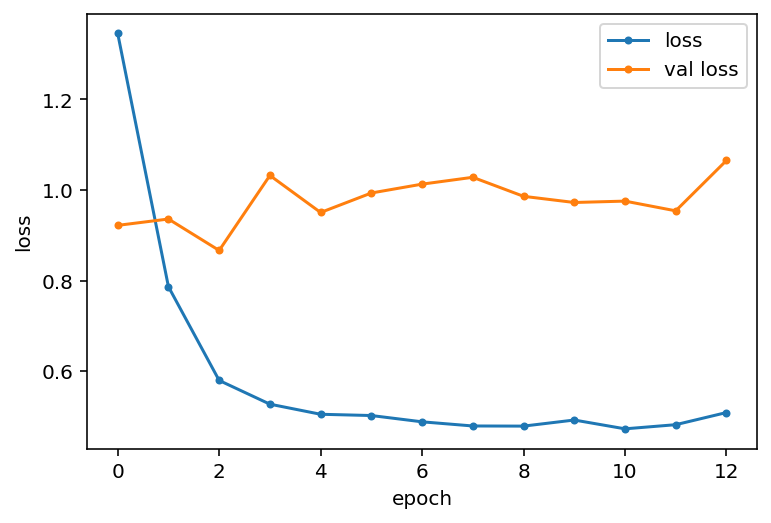

1909/1909 [==============================] - 25s 13ms/step - loss: 0.8248 - duration_loss: 0.2715 - pitch_loss: 6.2121 - step_loss: 0.0299 - velocity_loss: 3.8430 - duration_accuracy: 0.0000e+00 - pitch_sparse_categorical_accuracy: 6.3733e-04 - step_accuracy: 0.4056 - velocity_sparse_categorical_accuracy: 0.0199
test_ds losses :  {'loss': 0.8248174786567688, 'duration_loss': 0.27147772908210754, 'pitch_loss': 6.212057113647461, 'step_loss': 0.02988484874367714, 'velocity_loss': 3.8429982662200928, 'duration_accuracy': 0.0, 'pitch_sparse_categorical_accuracy': 0.0006373319192789495, 'step_accuracy': 0.4056312143802643, 'velocity_sparse_categorical_accuracy': 0.01991444081068039}


In [12]:
# 各種フォルダ作成
model_dir, checkpoints_dir, logdir, primary_dir = mkdirs()

# 乱数の種リセット
reset_seed(123)

# 学習（train / val）
if generate_only_flag != 1:
    print('\n*** 学習開始します ***\n')
    model = create_nn(seq_length, vocab_size, vel_size, key_order, model_dir)
    
    train(model, train_ds, val_ds, epochs, checkpoints_dir, logdir)
    
    # テスト評価
    test(model, test_ds)

### 5. note生成

音生成の初期設定

In [27]:
#============================================================================

# primary notes selector
# 0 : 学習データからランダムにシーケンス長分を抽出
# 1 : 自分のフレーズを先行notesとして使用
selector = 1

# 出力した音を選択する際、その確率変動させるパラメータ
temperature = 1

# 生成音数
num_predictions = 60

# 生成するmidi楽器の設定
instrument_name = 'Acoustic Grand Piano'

#============================================================================

inputs準備

In [28]:
def get_random_notes():
    """ inputsとしてtrain_dfで使用したnotes取得 """
    train_dir = os.path.join(BASE_DIR, 'data_notes')
    with open(os.path.join(train_dir, 'train_notes_df'), 'rb') as f:
        notes_df = pickle.load(f)
    sample_notes = notes_df[key_order]
    
    # seq_lengh分のnotesを、ランダムに抽出
    id = random.randint(0, len(sample_notes)-1)
    print('ranfdom id', id)
    pred_inputs = sample_notes[id:id+seq_length]
    pred_inputs = pred_inputs / [vocab_size, 1.0, 1.0, vel_size] # 正規化部分
    pred_inputs = pred_inputs.values.astype('float32')

    return pred_inputs,


def get_primary_notes(key_order):
    """ inputsとして自分のフレーズを取得
        (必ずsequence長以上のmidiデータを入力する事) """
    path = os.path.join(BASE_DIR, 'data_primary')
    midifile = glob.glob(os.path.join(path, '*.mid*'))

    notes_df,_ = get_notes2(midifile[0])
    notes_df = select_key_order(notes_df, key_order)

    display(notes_df.head(5))

    pred_inputs = notes_df[0:seq_length]
    pred_inputs_original = pred_inputs.copy()
    pred_inputs = pred_inputs / [vocab_size, 1.0, 1.0, vel_size] # 正規化部分
    pred_inputs = pred_inputs.values.astype('float32')

    return pred_inputs, pred_inputs_original


def get_notes2(midifile):
    """ midiからnote取得 """
    print('\n-----------------------------------------------------------')
    primary_notes  = [] # midiから変換したnotes
    midifile_n = []     # 各midiファイルのnote数を保持

    print(f'Parsing {midifile}')
    notes = midi_to_notes(midifile, correct_interval=0)
    
    midifile_n.append(len(notes))
    primary_notes.append(notes)
    primary_notes_df = pd.concat(primary_notes)
    
    # 各midifileのデータ数nを保持するmidifile_n_dict
    midifile_n_dict = dict((f_no, n) for f_no, n in enumerate(midifile_n))
    print('*** midifile_n_dict :', midifile_n_dict)

    return primary_notes_df, midifile_n_dict

In [29]:
# 学習データからランダムにシーケンス長分を抽出
if selector == 0:
    pred_inputs = get_random_notes()

# 自分のフレーズを先行notesとして使用
elif selector == 1:
    pred_inputs, pred_inputs_original = get_primary_notes(key_order)


-----------------------------------------------------------
Parsing /content/drive/MyDrive/LSTM_test220810/data_primary/piano100.mid
*** midifile_n_dict : {0: 641}


/usr/local/lib/python3.7/dist-packages/pretty_midi/pretty_midi.py:101: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  RuntimeWarning)


,pitch,step,duration,velocity
0,73,0.00,0.50,120
1,45,0.00,2.00,120
2,52,0.25,1.75,120
3,73,0.25,0.25,120
4,57,0.00,1.50,120


音生成

In [30]:
def generate_next_note(notes, model, temperature=1.0):
    """ note生成 """
    assert temperature > 0
    
    # batch次元を追加
    inputs = tf.expand_dims(notes, 0)

    predictions = model.predict(inputs) # inputs:ndarray、return:辞書型
    
    pitch_logits = predictions['pitch']
    velocity_logits = predictions['velocity']
    step = predictions['step']
    duration = predictions['duration']
    
    pitch_logits /= temperature
    velocity_logits /= temperature
    pitch = tf.random.categorical(pitch_logits, num_samples=1)  
    velocity = tf.random.categorical(velocity_logits, num_samples=1)

    # 列の次元のみ取得
    pitch = tf.squeeze(pitch, axis=-1)
    step = tf.squeeze(step, axis=-1)
    duration = tf.squeeze(duration, axis=-1)
    velocity = tf.squeeze(velocity, axis=-1)
    
    # stepとdurationは、正の値でなければならないので、強制補正
    if step < 0:     print('stepが負なので、強制的に 0.5 にします'     , step)
    if duration < 0: print('durationが負なので、強制的に +0.5 にします', duration)
    step = tf.maximum(0.5, step)
    duration = tf.maximum(0.5, duration)
    
    return int(pitch), float(step), float(duration), int(velocity)

In [31]:
# 各種フォルダ作成
model_dir, checkpoints_dir, logdir, primary_dir = mkdirs()

# 乱数の種リセット
reset_seed(123)

# モデル定義
model = create_nn(seq_length, vocab_size, vel_size, key_order, model_dir)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 20, 4)]      0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 20, 1024)    2117632     ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 20, 1024)    4096        ['bidirectional_1[0][0]']        
 rmalization)                                                                                     
                                                                                            

In [32]:
generated_notes = []
prev_start = 0

if selector == 1:
    for i in range(len(pred_inputs_original)):
        pitch, step, duration, velocity = pred_inputs_original.iloc[i, :]
        start = prev_start + step
        end = start + duration
        generate_note = (pitch, step, round(duration, 2), velocity)
        generated_notes.append((*generate_note, start, end))

for _ in range(num_predictions):
    # 次の音の予測
    pitch, step, duration, velocity = generate_next_note(pred_inputs, model, temperature)
    
    start = prev_start + step
    end = start + duration
    generate_note = (pitch, step, round(duration, 2), velocity)
    generated_notes.append((*generate_note, start, end))
    
    # 最古の音削除し、生成した音を追加したinputsを作成
    pred_inputs = pred_inputs[1:]
    pred_inputs =  np.append(pred_inputs, np.expand_dims(generate_note, 0), axis=0)
    prev_start = start

generated_notes = pd.DataFrame(generated_notes, columns=(*key_order, 'start', 'end'))

display(generated_notes.head(5))   

durationが負なので、強制的に +0.5 にします tf.Tensor([-0.00298357], shape=(1,), dtype=float32)
durationが負なので、強制的に +0.5 にします tf.Tensor([-0.00546981], shape=(1,), dtype=float32)
durationが負なので、強制的に +0.5 にします tf.Tensor([-0.00660016], shape=(1,), dtype=float32)
durationが負なので、強制的に +0.5 にします tf.Tensor([-5.2649528e-05], shape=(1,), dtype=float32)
durationが負なので、強制的に +0.5 にします tf.Tensor([-0.00218806], shape=(1,), dtype=float32)
durationが負なので、強制的に +0.5 にします tf.Tensor([-0.00299943], shape=(1,), dtype=float32)


,pitch,step,duration,velocity,start,end
0,73.0,0.00,0.50,120.0,0.00,0.5
1,45.0,0.00,2.00,120.0,0.00,2.0
2,52.0,0.25,1.75,120.0,0.25,2.0
3,73.0,0.25,0.25,120.0,0.25,0.5
4,57.0,0.00,1.50,120.0,0.00,1.5


### 6. 生成noteをmidiに出力

In [33]:
def notes_to_midi(notes, out_filename, instrument_name):
  """ noteをmidiにデコード """
  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program(instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])

    note = pretty_midi.Note(velocity=int(note['velocity']), pitch=int(note['pitch']), start=start, end=end)
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_filename)

  return pm

In [34]:
out_file = 'output.mid'
out_pm = notes_to_midi(generated_notes, out_file, instrument_name)

# 生成したmidiダウンロード
from google.colab import files
files.download(out_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 補足）midiデータ分析ツール：pianorollと音histgram

In [35]:
def listen_midi(midi_dir):
    """ colab上でmidi音源確認するためのツール """
    _SAMPLING_RATE = 16000 # Sampling rate for audio playback
    filenames = glob.glob(os.path.join(midi_dir, '*.mid*'))
    
    file_i = 1 # midi file選択
    
    sample_file = filenames[file_i]
    pm = pretty_midi.PrettyMIDI(sample_file)
    display_audio(pm)


def midi_to_notes2(pm):
    notes = collections.defaultdict(list)
    instrument = pm.instruments[0]
    
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start
    
    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['velocity'].append(note.velocity)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start
    
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})


def plot_piano_roll(notes):
    """ midi分析 : pianoroll作成 """
    count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop, plot_pitch, color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')


def plot_distributions(notes, drop_percentile=2.5):
    """ midi分析 : 音のhist分布作成 """
    plt.figure(figsize=[15, 5])
    plt.subplot(1, 4, 1)
    sns.histplot(notes, x="pitch", bins=20)
    
    plt.subplot(1, 4, 2)
    sns.histplot(notes, x="velocity", bins=20)
    
    plt.subplot(1, 4, 3)
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))
    
    plt.subplot(1, 4, 4)
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))


def display_audio(pm, seconds=30):
    """ prettymidiでのデコード確認 ===> デコードした音はおかしくならないGood！ """
    # Sampling rate for audio playback
    _SAMPLING_RATE = 16000
    waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
    # Take a sample of the generated waveform to mitigate kernel resets
    waveform_short = waveform[:seconds*_SAMPLING_RATE]
    
    return display.Audio(waveform_short, rate=_SAMPLING_RATE)

生成音のmidi分析

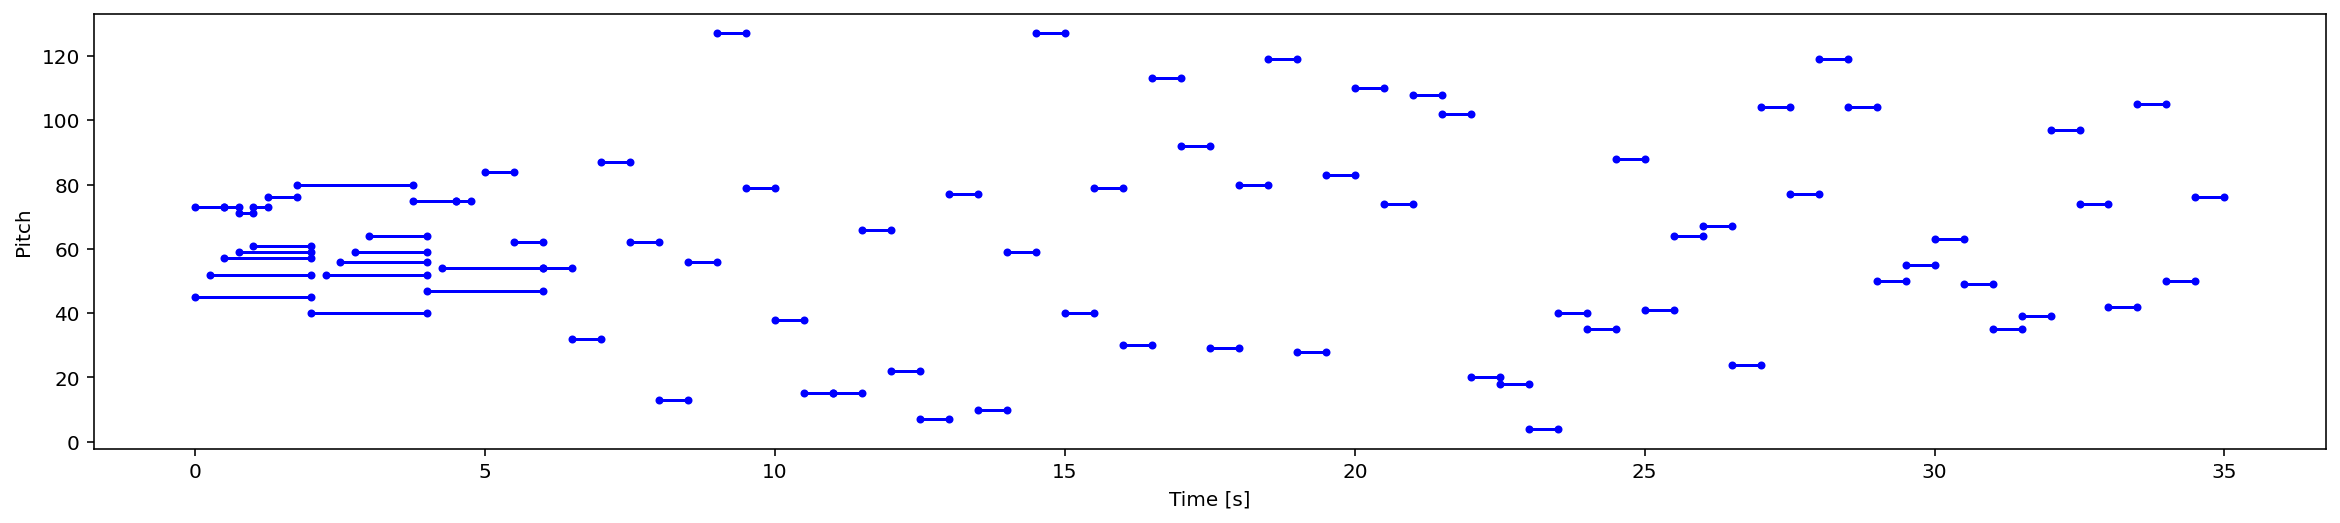

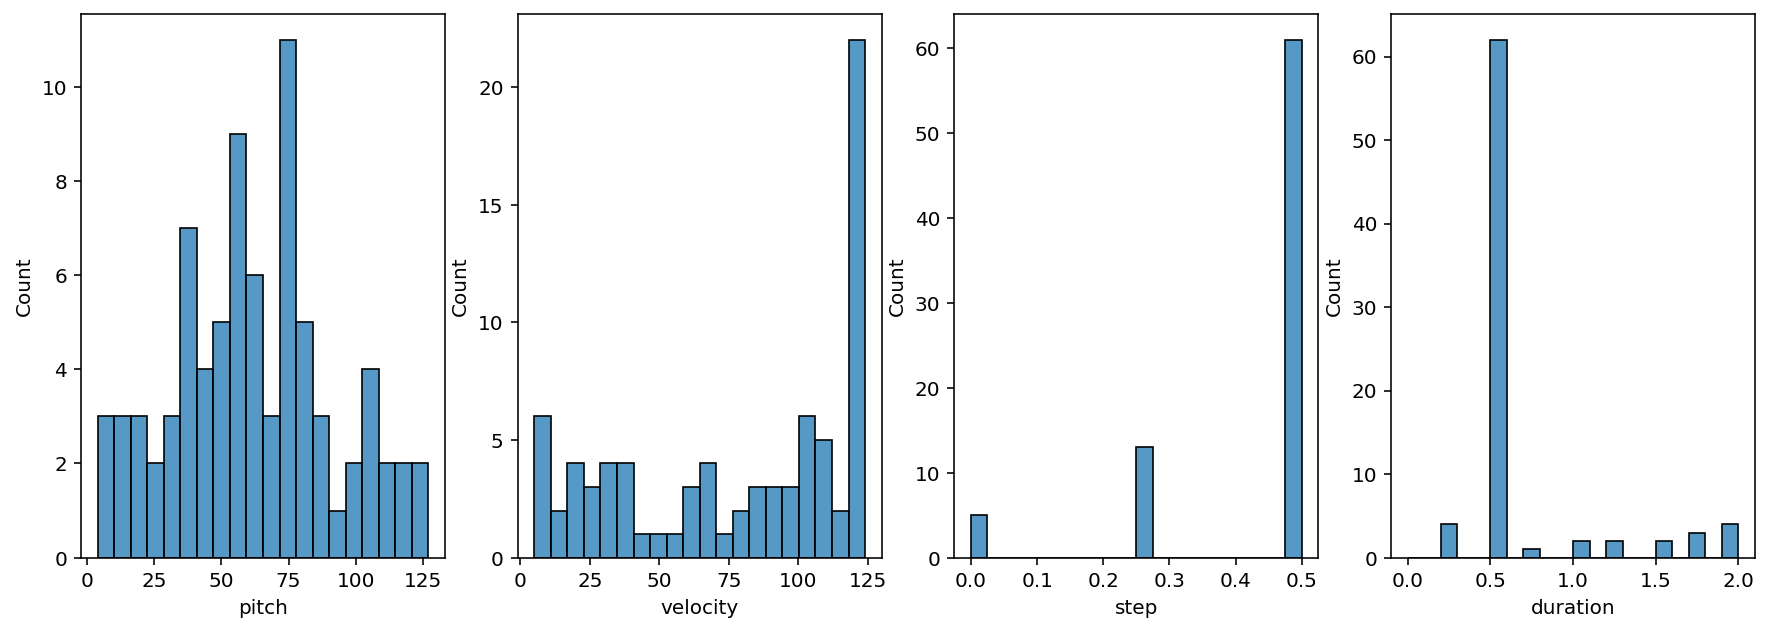

In [36]:
raw_notes = midi_to_notes2(out_pm)

plot_piano_roll(raw_notes)

plot_distributions(raw_notes)

In [26]:
print('============== program end ==============')

============== program end ==============
